In [1]:
from IPython.display import HTML
html = HTML("""
    <style>
        .backtick {
            font-style:oblique;
            font-family:"Courier New";
            font-size:15px;
        }
    </style>
""")
html

**NOTE FROM THE FUTURE (2019-Dec-16)**

<div style="background-color:sandybrown;">
    <p> This was some of the earliest work on the maternal project that I did, during
        the last week that Udi was still here, but after I did some of the initial RF work in the 
        previous notebook (prefixed <font class=backtick>00a__KU</font> in the new sub-repo 
        <font class=backtick>mbh001_v3</font>, or called <font class=backtick>modeling_f3_baseline_KU</font>
        in Udi's sub-repo <font class=backtick>mbh001_cu_v2</font>). </p>
    <p> Basically, the gist is this: while talking with our partners on Columbia on the phone,
        the topic of cesareans came up, and I realized  that a pre-scheduled cesarean
        might not be something we want to leave in the data set when predicting labor onset.  The
        idea is simple, and it is similar to when I was doing dropout modeling.  </p>
    <p> In the Substance
        Abuse Disorder (SUD) data set I was working with prior to taking over this maternal project, 
        we had patients who completed a
        treatment (fine), patients who left treatment against medical advice (great, this is what
        we consider "dropout" to be for our project), and then patients with a bunch of other reasons for
        "dropping out of treatment" that weren't really dropout (i.e., death, hospitalization,
        incarceration, moved to new state, etc).  I wanted to identify the risk of dropout, but
        thought the patients in this 3rd category, at best, just added noise to the data (e.g.,
        if we included them under the "dropout" label).  My view was that these patients
        represented "unlabeled" data: they would have either "completed treatment" or "dropped out,"
        but they were intervened upon first, making it impossible to know which.  </p>
    <p> In this situation (having unlabeled records),
        you have some options.  For one, you can use some clustering/labeling technique to impose
        labels on the unlabeled records.  Alternatively (and this is what I chose), you can
        assume that the unlabeled data is unlabeled completely at random -- thus, both the
        labeled and unlabled records faithfully represent the same patient population.  This means that,
        considering the unlabeled data is a small enough portion of the full data set, the
        unlabled data can be discarded before engaging in a supervised learning method.  </p>
    <p> It occurred to me that a pre-scheduled cesarean when predicting labor onset is a similar
        scenario:  the patient ends up without a "label" (in this case, the label stems from a
        continuous variable) due to an intervention that occurred before the labeling event
        could occur.  This patient would have had a label, but doesn't.  </p>
    <p> There is one caveat here: to my mind, the dropout interventions (death, hospitalization, 
        incarceration, relocation) can reasonably be assumed to occur at random (likely
        not totally true, but reasonable enough), it is not so straightforward that this is
        the case with cesareans.  For example, scheduling a cesarean probably means you've
        made it well past pre-term, which is not random - it biases towards normal-term deliveries.  Or, 
        better, one can imagine a class of cesareans that were scheduled after labor onset, which
        is definitely not at random (bias towards normal-term again).  However, some of the cesareans
        are likely due to conditions that correlate with pre-term delivery (i.e., doctors notice 
        complications and take charge before something bad happens).  So... Maybe there are enough
        sources driving cesareans that the cesarean class is distributed similarly enough in time
        to regular deliveries...  I think, no matter what, a cesarean represents noise and
        does not represent what we are trying to teach the model to learn, which is natural onset
        of labor and delivery.  </p>
    <p> Anyway, point is, I discussed this on the phone with Columbia during Udi's last week;
        it was generally agreed that we might get a performance boost if we were to selectively
        slim down the data set like this. </p>
    <p style="background-color:orange;"><b>NOTE</b>: This work was exploratory and 
        was my first foray into fudging around with and subsetting the data.  Much of the
        code here (loading the data, dealing with sparsity, imputation) is borrowed directly from
        Udi's last/latest Jupyter notebook, <font class=backtick>modeling_f3_baseline</font> 
        (though I added the cesarean parts in the early data loading and
        processing steps).  The underlying assumption made during this work is that Udi's final "full data table"
        that is used here is good enough to use (which may be debatable) and that most of his processing
        code used here was ok (I found that this wasn't strictly true as I worked on stuff, e.g., he
        was accidentally dropping most/all of his categorical variables). </p>
    <p><b>RESULTS</b>: 
        <ul>
            <li>Initially, removing cesareans seemed to strongly hurt the model performance, which led us
                to believe that there was something about the cesarean subpopulation we removed that
                had all the predictive power in it... However, this was not exactly the case (see next
                two bullets).</li>
             <li>One thing seems to be obvious: <b>This data set suffers from what Lee would call 
        the "curse of heterogeneity".</b> It is VERY HARD to not overfit to the training data, i.e., the
        data is heterogeneous enough that the validation data is almost never a great representation
                of the training data.  </li>
            <li><b>What's really strange</b> is that the major driver of
        model performance seems to be the random seed used for splitting the data.  This tells me
        that there is an "opportunistic split" for some random seeds where the training and
        validation data have more congruent, harmonious distributions relative to each other.  This
        gave me the idea to look at devising a stratification strategy for splitting the data, which
                I do in the next JNB (<font class=backtick>00c__KU</font> in 
                <font class=backtick>`mbh001_v3/notebooks/</font>). I started to get hints of
            this phenomenon in this notebook, but it wasn't until the next notebook that it truly
            dawned on me.</li> 
        </ul>
    </p>   
    <hr>
    <p style='background-color:orange;'> 
        <b>NOTE</b>: For analyses relevant to final report sent to Gates Foundation, please
        check out notebooks <font class=backtick>01_KU</font> through 
        <font class=backtick>04_KU</font> in <font class=backtick>mbh001/mbh001_v3</font>.
    </p>
    <hr>
    <p style='color:red;background-color:yellow;'><b>NOTE</b>: This notebook is copied to `mbh001_v3/notebooks` where it is prefixed `00b__KU`.</p>
</div>

-----------------------------------------------



In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy.stats import zscore,expon

In [2]:
pd.options.display.max_rows = 20

### Load data

In [3]:
dd = pickle.load( open( "../data/processed/mbh002_f3_toi_mon_baseline_a.p", "rb" ))
print(dd.shape)
dd.head()

(1548, 577)


adafppappa.afpga.10  adafppappa.afpga.15  \
patid                                                       
S002-BISH-00698                155.0                  NaN   
S002-BISH-00751                  NaN                  NaN   
S002-BISH-00809                  NaN                  NaN   
S002-BISH-00860                162.0                  NaN   
S002-BISH-00884                162.0                  NaN   

                 adafppappa.afpga.pre10  adafppappa.afpmom.10  \
patid                                                           
S002-BISH-00698                     NaN              0.963352   
S002-BISH-00751                     NaN                   NaN   
S002-BISH-00809                     NaN                   NaN   
S002-BISH-00860                     NaN              0.921191   
S002-BISH-00884                     NaN              0.864980   

                 adafppappa.afpmom.15  adafppappa.afpmom.pre10  \
patid                                                            
S002-BISH-00698                   NaN                      NaN   
S002-BISH-00751                   NaN                      NaN   
S002-BISH-00809                   NaN                      NaN   
S002-BISH-00860                   NaN                      NaN   
S002-BISH-00884                   NaN                      NaN   

                 adafppappa.pappaga.10  adcdrisc.cdrisc_nmiss.15  \
patid                                                              
S002-BISH-00698                   82.0                       0.0   
S002-BISH-00751                    NaN                       0.0   
S002-BISH-00809                    NaN                       0.0   
S002-BISH-00860                    NaN                       0.0   
S002-BISH-00884                    NaN                       0.0   

                 adcdrisc.cdrisc_nmiss.20  adcdrisc.cdrisc_raw.15  ...  \
patid                                                              ...   
S002-BISH-00698                       NaN                    33.0  ...   
S002-BISH-00751                       NaN                    88.0  ...   
S002-BISH-00809                       NaN                    85.0  ...   
S002-BISH-00860                       NaN                    75.0  ...   
S002-BISH-00884                       NaN                    84.0  ...   

                 adstai.r5_23.101520 adstai.r5_23.cycle.101520  \
patid                                                            
S002-BISH-00698                  4.0                        10   
S002-BISH-00751                  1.0                        10   
S002-BISH-00809                  1.0                        15   
S002-BISH-00860                  3.0                        10   
S002-BISH-00884                  1.0                        10   

                adstai.r5_1.101520 adstai.r5_1.cycle.101520  \
patid                                                         
S002-BISH-00698                4.0                       10   
S002-BISH-00751                1.0                       10   
S002-BISH-00809                1.0                       15   
S002-BISH-00860                1.0                       10   
S002-BISH-00884                1.0                       10   

                adstai.r5_16.101520 adstai.r5_16.cycle.101520  \
patid                                                           
S002-BISH-00698                 1.0                        10   
S002-BISH-00751                 4.0                        10   
S002-BISH-00809                 1.0                        15   
S002-BISH-00860                 3.0                        10   
S002-BISH-00884                 1.0                        10   

                adstai.t_anxiety.levels.101520 adstai.s_anxiety.levels.101520  \
patid                                                                           
S002-BISH-00698                              3                              3   
S002-BISH-00751                              2                        

In [4]:
cdata = pd.read_csv('../../mbh001_cu/data/processed/full_data_qc/mbh001_Data-Wide-QC-full-data_20190614_V1.csv', 
                    dtype={754: str, 757: str, 765: str, 855: str, 1225: str, 1226: str, 1229: str, 1475: str, 1485: str})

In [5]:
[item for item in cdata.columns if 'cesarean' in item.lower()]

['ADSCMAT.CesareanNoLabor2.ANY', 'ADSC.Cesarean2.25', 'ADMH.CesareanPrior2.5']

In [249]:
patient_set = cdata[cdata['ADSCMAT.CesareanNoLabor2.ANY']==0]['patid'].values

In [250]:
baseline_patient_set = set(patient_set).intersection(dd.index)

In [251]:
d = dd.loc[baseline_patient_set,:]

In [253]:
print('Shape of Full Shortlist:',dd.shape)
print('Shape of Shortlist w/o cWoL patients:',d.shape)

Shape of Full Shortlist: (1548, 577)
Shape of Shortlist w/o cWoL patients: (1449, 577)


### Remove sparse features
Keep features missing in less than 20% of the cases

In [230]:
na_th=0.8
#(d.isnull().sum()/len(d)).sort_values()

In [254]:
full_shortlist = True

if full_shortlist:
    df = dd.dropna(axis=1,thresh=len(d)*na_th)#.select_dtypes('float64')
else:
    df = d.dropna(axis=1,thresh=len(d)*na_th)#.select_dtypes('float64')


print(df.shape)
#df=df.astype('float64')
df.dtypes.value_counts()

(1548, 275)


object     169
float64    106
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a34cbcb70>]],
      dtype=object)

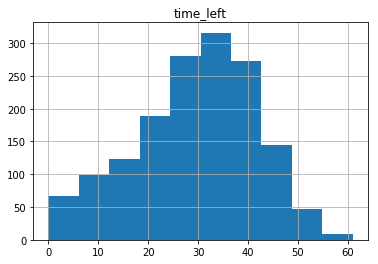

In [255]:
df.filter(like='time_left').hist()

In [256]:
# (df['time_left']<14).value_counts().plot.bar()

Text(0.5, 1.0, 'time left as a function of ga at f3')

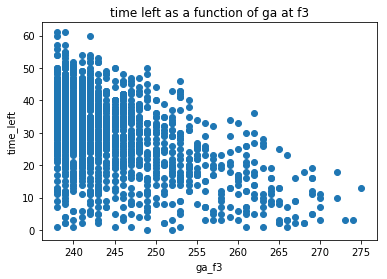

In [257]:
plt.scatter(x=df['ga_f3'],y=df['time_left'])
plt.xlabel('ga_f3')
plt.ylabel('time_left')
plt.title('time left as a function of ga at f3')

### Preparing X and y

In [258]:
X = df.drop(['time_left','ga.birth'],axis=1)
y = df['time_left']

In [259]:
num_feat=X.select_dtypes('float64').columns
cat_feat=X.select_dtypes('object').columns
sensor_features=X.filter(regex='^toi|^mon').columns
#X[cat_feat]=X[cat_feat].astype('str'`)
#X[cat_feat].filter(like='gender')

In [260]:
X[cat_feat].dtypes.value_counts()
X[num_feat].dtypes.value_counts()

float64    104
dtype: int64

In [261]:
# Overlap between feature types
n_X = len(X.columns)
n_num_feat = len(num_feat)
n_cat_feat = len(cat_feat)
n_sensor_features = len(sensor_features)
print('n_X:', n_X)
print('n_num_feat:', n_num_feat)
print('n_cat_feat:', n_cat_feat)
print('n_sensor_features:', n_sensor_features)
print('nn + nc + ns:', n_num_feat + n_cat_feat + n_sensor_features)

n_X: 273
n_num_feat: 104
n_cat_feat: 169
n_sensor_features: 44
nn + nc + ns: 317


## Feature engineering - Numeric



### Creating missing values indicators

In [262]:
for feat in num_feat:
    missing_indicator_feat_name=feat+'_nan'
    X[missing_indicator_feat_name] = X[feat].isnull().astype(int)

### Imputing medians

In [263]:
X[num_feat] = X[num_feat].fillna(X[num_feat].median())

In [264]:
create_transformed_feats = False   # Unnecessary for Random Forests
if create_transformed_feats:
    for feat in num_feat:
        square_feat_name=feat+'_square'
        cube_feat_name=feat+'_cube'
        log_feat_name=feat+'_log'
        sqrt_feat_name=feat+'_sqrt'
        X[square_feat_name]=np.power(X[feat],2)
        X[cube_feat_name]=np.power(X[feat],3)
        X[sqrt_feat_name]=np.power(X[feat]-X[feat].min(),0.5)
        X[log_feat_name]=np.log(X[feat]-X[feat].min()+1) 

In [265]:
len(X.columns)

377

## Feature engineering - Categorical
Create dummies removing dirst category

In [266]:
X[cat_feat] = X[cat_feat].astype('float64')

In [267]:
cat_feat_dummies = pd.get_dummies(X[cat_feat], dummy_na=True, drop_first=True)
X = pd.concat([X, cat_feat_dummies], axis=1).drop(cat_feat, axis=1)


##########
XX = pd.concat([X, cat_feat_dummies], axis=1).drop(cat_feat, axis=1)


### NOTE (2019-Nov-07)
Udi/Carlos end up accidentally dropping MOST of the categorical vars.  See below.

In [81]:
len(X.columns)

377

In [60]:
len(cat_feat_dummies.columns)

169

In [83]:
pd.concat([X, cat_feat_dummies], axis=1).columns

Index(['adcompl.prenatal2.any', 'addrg_patid.anydrugs2.preg',
       'addrg_patid.anyhair2.preg', 'addrg_patid.anymeth2.preg',
       'addrg_patid.anymj2.preg', 'addrg_patid.anymjmeth2.preg',
       'addrg_patid.anyother2.preg', 'addrg_patid.hair12wk2.preg',
       'addrg_patid.hair19wk2.preg', 'addrg_patid.hair1yrprior2.preg',
       ...
       'adstai.r5_39.cycle.101520', 'adstai.r5_20.cycle.101520',
       'adstai.r5_2.cycle.101520', 'adstai.t_anxiety_agepct.cycle.101520',
       'adstai.r5_34.cycle.101520', 'adstai.r5_23.cycle.101520',
       'adstai.r5_1.cycle.101520', 'adstai.r5_16.cycle.101520',
       'adstai.t_anxiety.levels.101520', 'adstai.s_anxiety.levels.101520'],
      dtype='object', length=546)

In [84]:
pd.concat([X, cat_feat_dummies], axis=1).drop(cat_feat, axis=1).columns

Index(['addrg_patid.tothairlmp.preg', 'addrg_patid.tothairt1.preg',
       'addrg_patid.tothairt2.preg', 'addrg_patid.totmethlmp.preg',
       'addrg_patid.totmetht1.preg', 'addrg_patid.totmetht2.preg',
       'addrg_patid.totmjlmp.preg', 'addrg_patid.totmjt1.preg',
       'addrg_patid.totmjt2.preg', 'addrg_patid.tototherlmp.preg',
       ...
       'adstai.s_anxiety.101520_nan', 'adstai.r5_39.101520_nan',
       'adstai.r5_20.101520_nan', 'adstai.r5_2.101520_nan',
       'adstai.t_anxiety_agepct.101520_nan', 'adstai.r5_34.101520_nan',
       'adstai.r5_23.101520_nan', 'adstai.r5_1.101520_nan',
       'adstai.r5_16.101520_nan', 'ga_f3_nan'],
      dtype='object', length=208)

In [85]:
cat_feat

Index(['adcompl.prenatal2.any', 'addrg_patid.anydrugs2.preg',
       'addrg_patid.anyhair2.preg', 'addrg_patid.anymeth2.preg',
       'addrg_patid.anymj2.preg', 'addrg_patid.anymjmeth2.preg',
       'addrg_patid.anyother2.preg', 'addrg_patid.hair12wk2.preg',
       'addrg_patid.hair19wk2.preg', 'addrg_patid.hair1yrprior2.preg',
       ...
       'adstai.r5_39.cycle.101520', 'adstai.r5_20.cycle.101520',
       'adstai.r5_2.cycle.101520', 'adstai.t_anxiety_agepct.cycle.101520',
       'adstai.r5_34.cycle.101520', 'adstai.r5_23.cycle.101520',
       'adstai.r5_1.cycle.101520', 'adstai.r5_16.cycle.101520',
       'adstai.t_anxiety.levels.101520', 'adstai.s_anxiety.levels.101520'],
      dtype='object', length=169)

In [87]:
cat_feat_dummies.columns

Index(['adcompl.prenatal2.any', 'addrg_patid.anydrugs2.preg',
       'addrg_patid.anyhair2.preg', 'addrg_patid.anymeth2.preg',
       'addrg_patid.anymj2.preg', 'addrg_patid.anymjmeth2.preg',
       'addrg_patid.anyother2.preg', 'addrg_patid.hair12wk2.preg',
       'addrg_patid.hair19wk2.preg', 'addrg_patid.hair1yrprior2.preg',
       ...
       'adstai.r5_39.cycle.101520', 'adstai.r5_20.cycle.101520',
       'adstai.r5_2.cycle.101520', 'adstai.t_anxiety_agepct.cycle.101520',
       'adstai.r5_34.cycle.101520', 'adstai.r5_23.cycle.101520',
       'adstai.r5_1.cycle.101520', 'adstai.r5_16.cycle.101520',
       'adstai.t_anxiety.levels.101520', 'adstai.s_anxiety.levels.101520'],
      dtype='object', length=169)

In [88]:
#X = df.drop(['time_left','ga.birth'],axis=1)
#y = df['time_left']

In [126]:
#[X[feat].unique().tolist() for feat in cat_feat]

array([0, 1])

### train model function

In [151]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [23]:
def train_model_cv(
    X_train,
    y_train,
    model='lasso',
    n_iter=50,
    kfolds=3,
    random_state=42,
):
    ''' Function to fit a model and tune hyper parameters using five fold cross validation
       
    Parameters
    ----------
    X_train : training features
    Y_train: training target
    model: model name
    '''
    
    regs={'lasso': Lasso(selection='random',random_state=random_state),
          'rf':RandomForestRegressor(random_state=42),
          #'xgbtree':XGBRegressor(silent=True,early_stopping_rounds=10,eval_metric="mae",eval_set=[(X_train,y_train)],random_state=42),
          #'xgbdart':XGBRegressor(silent=True,early_stopping_rounds=10,eval_set=[(X_train,y_train)],booster='dart',random_state=42),
          #'xgblinear':XGBRegressor(silent=True,early_stopping_rounds=10,eval_set=[(X_train,y_train)],booster='gblinear',random_state=42),
          'gbmreg':GradientBoostingRegressor(loss='quantile',random_state=42),
         'enet':ElasticNet(selection='random',random_state=42)}
    grids = {'lasso':
                {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.6,0.8,0.9,1,2,5],
                 'normalize':[True,False],
                 'positive':[True,False]
                },
             'enet':
                {'alpha':[0.1,0.2,0.3,0.4,0.5,1,2,5],
                 'l1_ratio':[0,0.5,1],
                 'normalize':[False],
                 'positive':[True,False]
                },
             'rf':
                {'n_estimators': [10,100,500,1000],
                 'max_features': ['auto','sqrt'],
                 'max_depth': [3,5,8],
                 'min_samples_split':[2, 5, 10],
                 'min_samples_leaf':[1, 2, 4]
                },
             'xgbtree':
                 {'learning_rate': expon(scale=.1),
                  'max_depth': [2,3,5],
                  'n_estimators': [10,100,200,500],
                  'subsample':[0.5,0.8,1],
                  'alpha':[1,5,10,20,50],
                  'gamma':[20,50,100,200],
                  'lambda': [0.1,0.2,0.3,0.4,0.5,1,2,5],
                  'rate_drop':[0,0.2,0.4,0.6,0.8,1]},
             'xgbdart':
                 {'learning_rate': expon(scale=.1),
                  'max_depth': [2,3,5],
                  'n_estimators': [10,100,200,500],
                  'subsample':[0.5,0.8,1],
                  'rate_drop':[0,0.2,0.4,0.6,0.8,1]},
             'xgblinear':
                 {'alpha':[0.1,1,5,10],
                  'lambda': [0.1,0.2,0.3,0.4,0.5,1,2,5],
                  'n_estimators': [10,100,200,500],
                  'subsample':[0.5,0.8,1],
                  'rate_drop':[0,0.2,0.4,0.6,0.8,1]},
             'gbmreg':{'n_estimators': [10,100,250],
                 'max_depth': [3,5,8],
                 'min_samples_split':[2, 5, 10,20],
                 'min_samples_leaf':[2, 5, 10,20]
                }
            }
    
    reg=RandomizedSearchCV(regs[model],
                           grids[model],
                           n_jobs=-1,
                           cv=kfolds,
                           n_iter=n_iter,
                           return_train_score=True,
                           scoring=['r2','neg_mean_absolute_error','neg_median_absolute_error'],
                          refit='neg_mean_absolute_error')
    reg.fit(X_train,y_train)
    return(reg)

### Null model
**NOTE**: Here, you will see I change Udi's `random_state` from 42 to 37.  This is around when 
I started realizing how sensitive model performance was to random seed selection...

In [24]:
#random_state=42
random_state = 37
X_train, X_dev, y_train, y_dev = train_test_split(X['ga_f3'], y, test_size=0.3, random_state=random_state)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=random_state)

pred = np.full(len(y_dev),np.mean(y_dev))

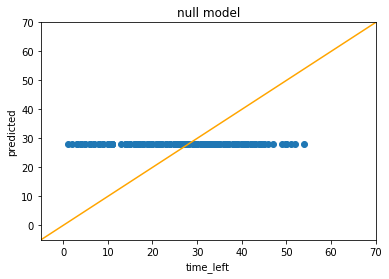

MAE dev: 9.462464694514644
R2 dev: 0.0


In [185]:
plt.scatter(y_dev,pred)
plt.xlim((-5,70))
plt.ylim((-5,70))
plt.plot( [-5,70],[-5,70],color='orange')
plt.xlabel('time_left')
plt.ylabel('predicted')
plt.title('null model')
plt.show()
print('MAE dev: {}'.format(mean_absolute_error(y_dev,pred)))
print('R2 dev: {}'.format(r2_score(y_dev,pred)))

In [186]:
# plt.scatter(X_dev,y_dev)
# plt.xlabel('ga_f3')
# plt.ylabel('time_left')
# plt.title('Null model')
# plt.hlines(pred,xmin=235,xmax=270,colors='orange')
# print('MAE: {}'.format(np.mean(np.abs(pred-y_dev))))
# print('R2: {}'.format(r2_score(y_dev,pred)))

### ga_f3 model
univariate regression

In [187]:
X_train, X_dev, y_train, y_dev = train_test_split(X['ga_f3'], y, test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

reg = Lasso().fit(X_train.values.reshape(-1,1), y_train)

#reg.score(X_dev.values.reshape(-1,1), y_dev)

pred=reg.predict(X_dev.values.reshape(-1,1))

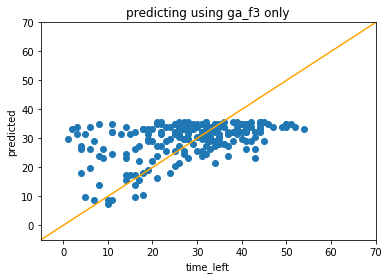

MAE dev: 8.073769278458565
R2 dev: 0.2034010963027869


In [188]:
plt.scatter(y_dev,pred)
plt.xlim((-5,70))
plt.ylim((-5,70))
plt.plot( [-5,70],[-5,70],color='orange')
plt.xlabel('time_left')
plt.ylabel('predicted')
plt.title('predicting using ga_f3 only')
plt.show()
print('MAE dev: {}'.format(mean_absolute_error(y_dev,pred)))
print('R2 dev: {}'.format(r2_score(y_dev,pred)))

### GA_F3+demo+clinical 

In [25]:
#random_state=42
random_state=37

modName = 'rf'
X_train, X_dev, y_train, y_dev = train_test_split(X.drop(sensor_features, axis=1), y, test_size=0.3, random_state=random_state)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=random_state)

model = train_model_cv(X_train, y_train, model=modName, n_iter=150)

In [26]:
pred=model.predict(X_dev)

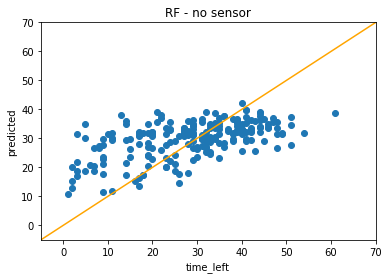

MAE train: 5.056323419182304
MAE dev: 8.488091291178542
R2 train: 0.7125302998571946
R2 dev: 0.3014578125614591


In [30]:
plt.scatter(y_dev,pred)
plt.xlim((-5,70))
plt.ylim((-5,70))
plt.plot( [-5,70],[-5,70],color='orange')
plt.xlabel('time_left')
plt.ylabel('predicted')
plt.title(f'{modName.upper()} - no sensor')
plt.show()

print('MAE train: {}'.format(mean_absolute_error(y_train,model.predict(X_train))))
print('MAE dev: {}'.format(mean_absolute_error(y_dev,model.predict(X_dev))))
print('R2 train: {}'.format(r2_score(y_train,model.predict(X_train))))
print('R2 dev: {}'.format(r2_score(y_dev,model.predict(X_dev))))

In [148]:
feat_importance_df=pd.DataFrame({'feature':X_train.columns,'importance':np.abs(model.best_estimator_.coef_)})
feat_importance_df.sort_values('importance',ascending=False)

feature  importance
59                                    ga_f3    0.876192
57                       adstai.r5_1.101520    0.664172
16                    adscmat.gravidity.any    0.648171
37                      adstai.r5_27.101520    0.626826
43                      adstai.r5_15.101520    0.619012
39                       adstai.r5_8.101520    0.615085
34                      adstai.r5_26.101520    0.512017
84             advs_long.weighttlfu1.20_nan    0.342096
8                  addrg_patid.totmjt2.preg    0.299077
33                      adstai.r5_21.101520    0.293588
..                                      ...         ...
76                adscmat.gravidity.any_nan    0.000000
75   adfetalgrowth.lm_linear_coeff.preg_nan    0.000000
74                     adelig.mat_age.5_nan    0.000000
73                     adelig.enryear.5_nan    0.000000
72                        adelig.ccga.5_nan    0.000000
71          addrg_patid.totothert2.preg_nan    0.000000
70          addrg_patid.totothert1.preg_nan    0.000000
69         addrg_patid.tototherlmp.preg_nan    0.000000
68             addrg_patid.totmjt2.preg_nan    0.000000
163                               ga_f3_nan    0.000000

[164 rows x 2 columns]

In [ ]:
# plt.scatter(X_dev['ga_f3'],y_dev)
# plt.scatter(X_dev['ga_f3'],pred)
# plt.xlabel('ga_f3')
# plt.ylabel('time_left')
# plt.title('GA_F3+demo+clinical ')
# print('MAE: {}'.format(np.median(np.abs(pred-y_dev))))
# print('R2: {}'.format(r2_score(y_dev,pred)))

### GA_F3+demo+clinical+sensor

In [277]:
#random_state=42
random_state=42

modName = 'rf'

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=random_state)

model=train_model_cv(X_train,y_train,model=modName)

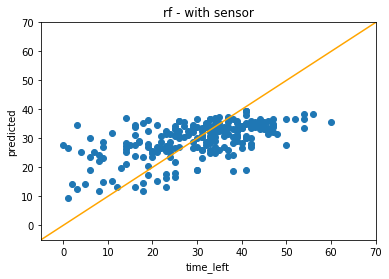

MAE train: 5.119151017962678
MAE dev: 7.996924490075657
R2 train: 0.6880789371625559
R2 dev: 0.34001172443887406


In [276]:
plt.scatter(y_dev, model.predict(X_dev))
plt.xlim((-5,70))
plt.ylim((-5,70))
plt.plot( [-5,70],[-5,70], color='orange')
plt.xlabel('time_left')
plt.ylabel('predicted')
plt.title(f'{modName} - with sensor')
plt.show()

print('MAE train: {}'.format(mean_absolute_error(y_train, model.predict(X_train))))
print('MAE dev: {}'.format(mean_absolute_error(y_dev, model.predict(X_dev))))
print('R2 train: {}'.format(r2_score(y_train, model.predict(X_train))))
print('R2 dev: {}'.format(r2_score(y_dev, model.predict(X_dev))))

In [ ]:
feat_importance_df=pd.DataFrame({'feature':X_train.columns,'importance':np.abs(model.best_estimator_.coef_)})
feat_importance_df.sort_values('importance',ascending=False)

# Exploring 42
Is there a dependence on random seed?  (Weird...)

In [278]:
random_state=42
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=random_state)

In [294]:
patient_set = cdata[cdata['ADSCMAT.CesareanNoLabor2.ANY']==0]['patid'].values
baseline_patient_set = set(patient_set).intersection(dd.index)

cwol = cdata[cdata['ADSCMAT.CesareanNoLabor2.ANY']==1]['patid'].values
cwol_intersect_shortlist = set(cwol).intersection(dd.index)
cwol_diff_shortlist = set(cwol).difference(dd.index)
#shortlist_diff_ = set(cwol).difference(dd.index)

cwol_intersect_Xtrn = set(cwol).intersection(X_train.index)
cwol_intersect_Xdev = set(cwol).intersection(X_dev.index)


In [290]:
len(cwol)

281

In [291]:
len(cwol_intersect_shortlist)

50

In [292]:
len(cwol_diff_shortlist)

218

In [295]:
len(cwol_intersect_Xtrn)

34

In [296]:
len(cwol_intersect_Xdev)

10